# Neural Style Transfer

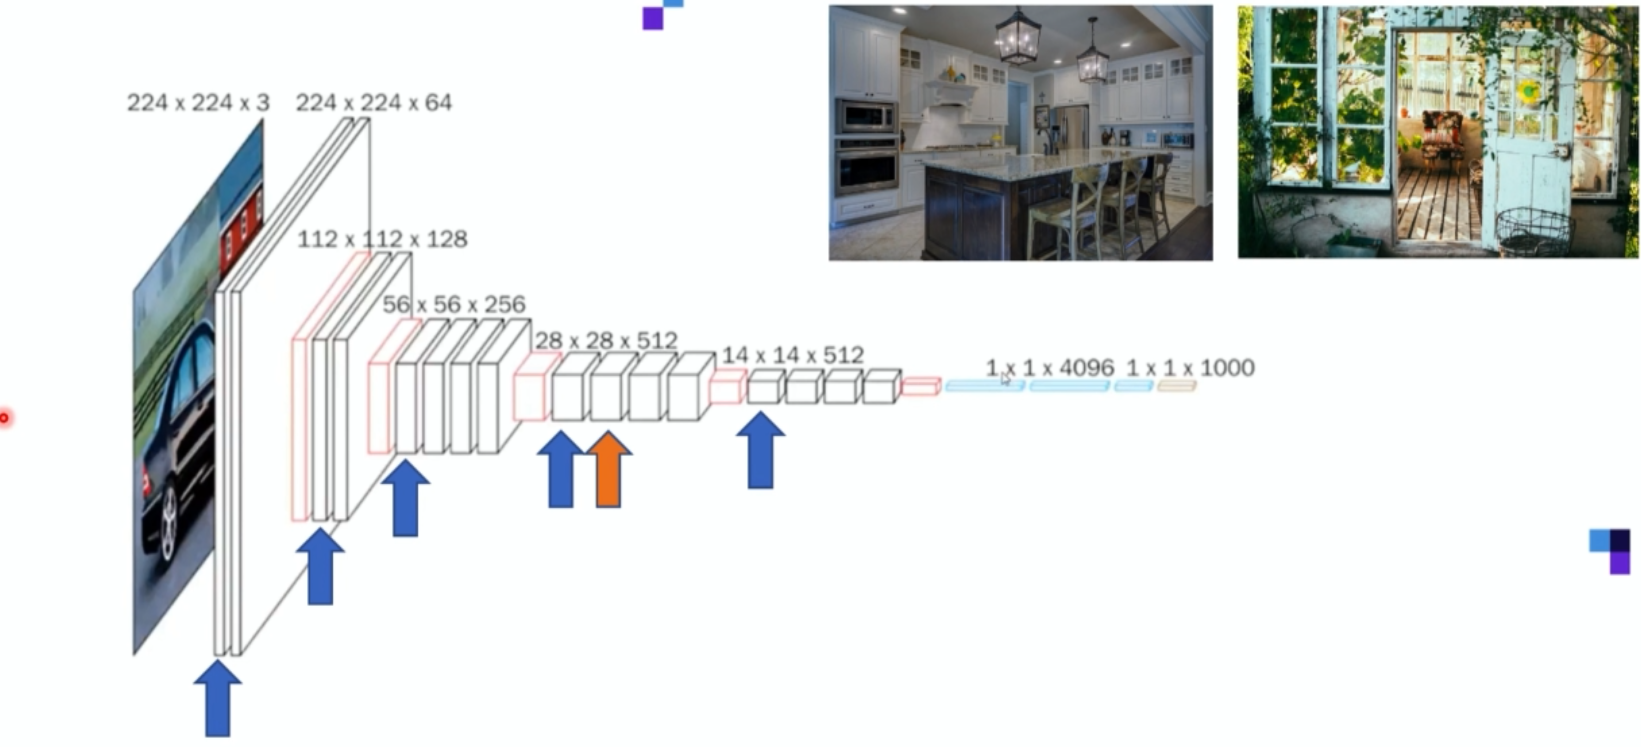

### Let's first get some idea of how the transfer learning works
As you can see in fig above, we have 2 images and VGG19 structure:
- Both images have content and style.
- **Content:** is general, as the content in both images above is house.
- **Style:** can be different, as both images have different style.
- The style layers are mainly the first layer of each convolutional block
- We will use special type of model called **VGG19**, this has lots of Convolutional layers as shown.
- The **red** one has the **content** of the image, and the **blue** has the **style** of the image.
- So we will copy the style to another image

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.applications import VGG19

In [2]:
base_model = VGG19(weights='imagenet', include_top=False)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [3]:
base_model.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 20,024,384 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
def preprocess_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path)
    img = tf.keras.preprocessing.image.img_to_array(img)
    #mg = tf.keras.applications.vgg19.preprocess_input(img)
    # We just simply divide by maximum value
    img = img / 255.0
    return img


In [5]:
style1 = preprocess_image('/content/art.jpg')
style2 = preprocess_image('/content/art2.png')
content1 = preprocess_image('/content/Crop DP.jpeg')

In [6]:
style1.shape, style2.shape, content1.shape

((445, 720, 3), (663, 1200, 3), (572, 606, 3))

In [7]:
style1.min(), style1.max()

(0.0, 1.0)

As you can see the images are now preprocessed

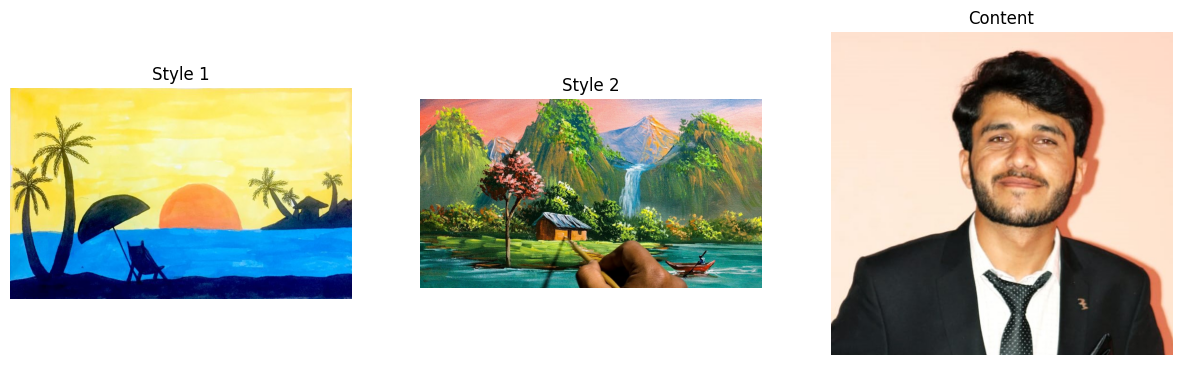

In [8]:
# Let's show all images.
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(style1)
ax[1].imshow(style2)
ax[2].imshow(content1)
ax[0].set_title('Style 1')
ax[1].set_title('Style 2')
ax[2].set_title('Content')
for a in ax:
    a.axis('off')
plt.show();

As you can see the images, now we will process these images

Now we will define some layers for content and style and a function to extract those layers

In [9]:
content_layers = ['block4_conv1']
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

In [10]:
def extract_features(layer_names):
  vgg = VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  outputs = [vgg.get_layer(name).output for name in layer_names]
  model = tf.keras.Model(inputs = [vgg.input], outputs = outputs)
  return model

In [11]:
style_extractor = extract_features(style_layers)

In [12]:
style_extractor.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,944,960 (49.38 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 12,944,960 (49.38 MB)

As you can see we have all layers, but the output should be only from selected layers as shown below

In [13]:
style_extractor.output

[<KerasTensor shape=(None, None, None, 64), dtype=float32, sparse=False, name=keras_tensor_23>,
 <KerasTensor shape=(None, None, None, 128), dtype=float32, sparse=False, name=keras_tensor_26>,
 <KerasTensor shape=(None, None, None, 256), dtype=float32, sparse=False, name=keras_tensor_29>,
 <KerasTensor shape=(None, None, None, 512), dtype=float32, sparse=False, name=keras_tensor_34>,
 <KerasTensor shape=(None, None, None, 512), dtype=float32, sparse=False, name=keras_tensor_39>]

In [14]:
style_output = style_extractor(tf.expand_dims(style1, 0))

In [15]:
len(style_output)

5

In [16]:
style_output[0].shape, style_output[1].shape, style_output[2].shape, style_output[3].shape, style_output[4].shape

(TensorShape([1, 445, 720, 64]),
 TensorShape([1, 222, 360, 128]),
 TensorShape([1, 111, 180, 256]),
 TensorShape([1, 55, 90, 512]),
 TensorShape([1, 27, 45, 512]))

In order to transfer the style from one image to another, we need to calculate the gram_matrix
- **Gram Matrix** used to measure the loss between the generated image and styled image

In [17]:
def gram_matrix(layer_activation):
  result = tf.linalg.einsum('bijc,bijd->bcd', layer_activation, layer_activation) # The shape of activation is (a, b, c, d) correspond to (b,i,j,c). So it will change to (x, y, z)
  input_shape = tf.shape(layer_activation)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)

  return result / num_locations

In [18]:
style_output[0].shape

TensorShape([1, 445, 720, 64])

In [19]:
gram_output_0 = gram_matrix(style_output[0])
gram_output_0.shape

TensorShape([1, 64, 64])

As you can see the shapes has been reduced

In [20]:
gram_output_1 = gram_matrix(style_output[1])
style_output[1].shape, gram_output_1.shape

(TensorShape([1, 222, 360, 128]), TensorShape([1, 128, 128]))

Let's create the clas swith everytihng that we have done so far

In [21]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super().__init__()
    self.vgg = extract_features(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.num_content_layers = len(content_layers)
    self.vgg.trainable=False

  def call(self, inputs):
    input = inputs * 255 # To get the image as original 1 [0, 255]
    preprocessed_image = tf.keras.applications.vgg19.preprocess_input(input)
    preprocessed_image = tf.expand_dims(preprocessed_image, 0)
    outputs = self.vgg(preprocessed_image)
    styled_outputs = outputs[:self.num_style_layers]
    content_outputs = outputs[self.num_style_layers:]
    style_features = [gram_matrix(style_output) for style_output in styled_outputs]

    content_dict = {content_name: value for content_name, value in zip(self.content_layers, content_outputs)}
    style_dict = {style_name: value for style_name, value in zip(self.style_layers, style_features)}

    return {'content': content_dict, 'style': style_dict}

Next we will do the following steps:
- Get the style_targets, and content_targets. In the resulted image, the style and content will be compare to the original style image and content image respectively in order to minimize loss during training.
- We will define 2 important parameters
- 1 Style_weight (The amount of style content you want in final image)
- 2 Content_weight (The amount of content you want in final image)

In [22]:
extractor = StyleContentModel(style_layers, content_layers)

In [23]:
# This will automatically call the "call" method defined in class
style_targets = extractor(style1)['style']
content_targets = extractor(content1)['content']

In [24]:
len(style_targets), len(content_targets)

(5, 1)

In [25]:
new_image = tf.Variable(content1) # This will be the resulted image, and will be compared in training process

In [26]:
content_weight = 1
style_weight = 1000

In [27]:
optimizer = tf.optimizers.Adam(learning_rate=0.02)

### Let's do the training

Epoch 0, content_loss: 0.0 style_loss: 49862770688.0 total_loss: 9972554399744.0
(572, 606, 3)


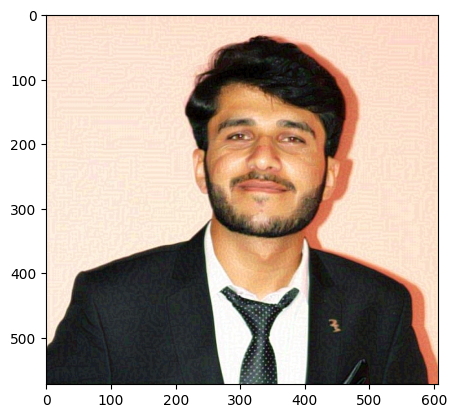

Epoch 500, content_loss: 469654.28125 style_loss: 2640264192.0 total_loss: 528053305344.0
(572, 606, 3)


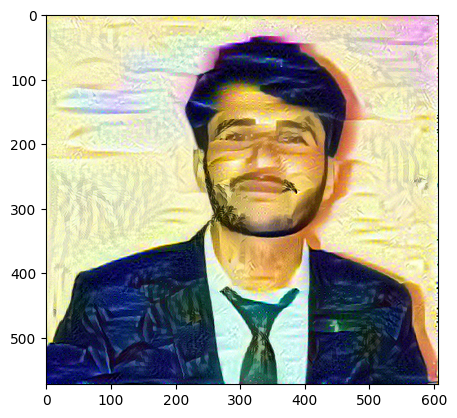

Epoch 1000, content_loss: 483164.0625 style_loss: 540262208.0 total_loss: 108052922368.0
(572, 606, 3)


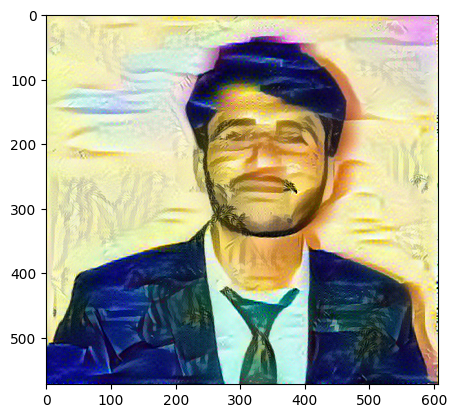

Epoch 1500, content_loss: 510038.0625 style_loss: 1892366464.0 total_loss: 378473807872.0
(572, 606, 3)


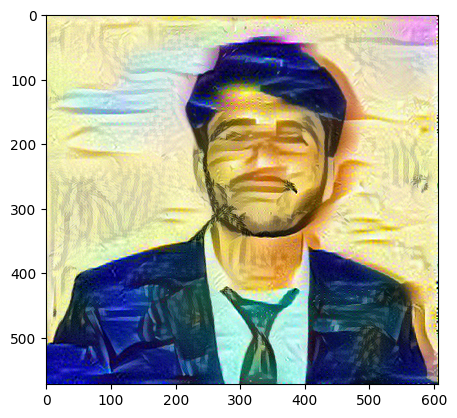

Epoch 2000, content_loss: 509067.8125 style_loss: 430665824.0 total_loss: 86133669888.0
(572, 606, 3)


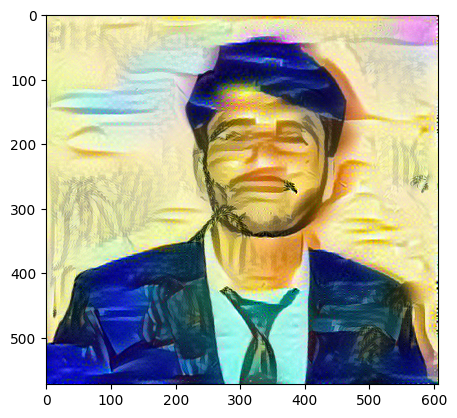

Epoch 2500, content_loss: 511080.8125 style_loss: 274127168.0 total_loss: 54825947136.0
(572, 606, 3)


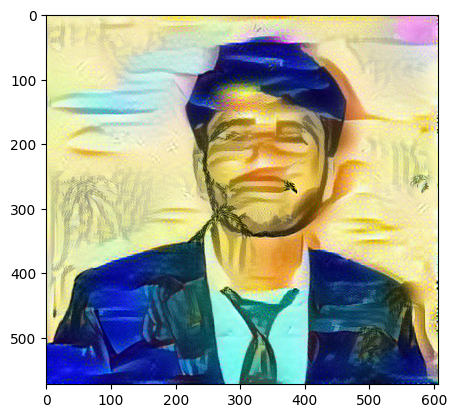

Epoch 3000, content_loss: 515306.6875 style_loss: 260942304.0 total_loss: 52188975104.0
(572, 606, 3)


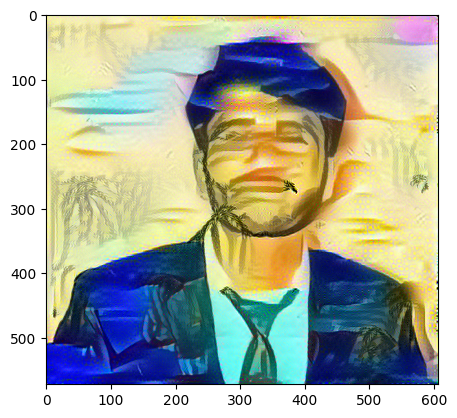

Epoch 3500, content_loss: 521629.125 style_loss: 242280304.0 total_loss: 48456581120.0
(572, 606, 3)


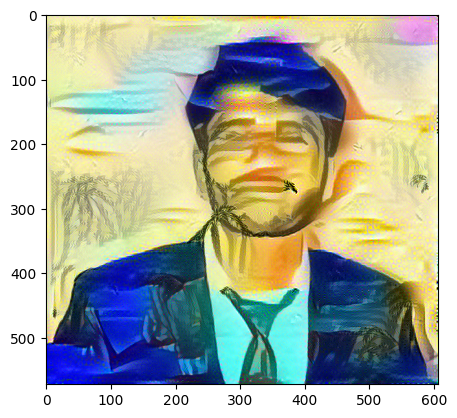

Epoch 4000, content_loss: 529251.25 style_loss: 279297216.0 total_loss: 55859974144.0
(572, 606, 3)


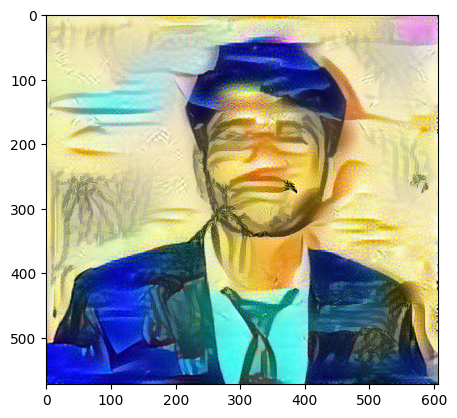

Epoch 4500, content_loss: 535169.875 style_loss: 320067424.0 total_loss: 64014024704.0
(572, 606, 3)


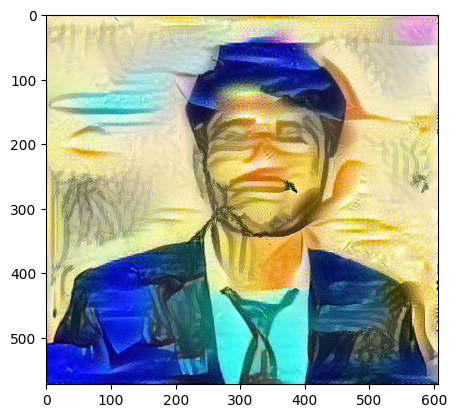

In [28]:
epochs = 5000
print_every = 500

for epoch in range(epochs):
  with tf.GradientTape() as tape: # We need this because at each iteration, we need to change the value of each pixel
    output = extractor(new_image) # On the newly generated image

    content_outputs = output['content']
    style_outputs = output['style']

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name]) ** 2) for name in content_outputs.keys()])
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name]) ** 2) for name in style_outputs.keys()])

    total_loss = content_weight * content_loss / len(content_layers)  + style_weight * style_loss / len(style_layers)

  grad = tape.gradient(total_loss, new_image)
  optimizer.apply_gradients([(grad, new_image)])

  new_image.assign(tf.clip_by_value(new_image, clip_value_min=0.0, clip_value_max=1))
  if epoch % print_every == 0:
    print(f'Epoch {epoch}, content_loss: {content_loss} style_loss: {style_loss} total_loss: {total_loss}')
    print(new_image.shape)

    plt.imshow(new_image)
    plt.show();
